In [12]:
import requests
import gzip
import shutil

url = 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/'

filenames = ['StormEvents_details-ftp_v1.0_d2009_c20180718.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2010_c20170726.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2011_c20180718.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2012_c20190516.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2013_c20170519.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2014_c20180718.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2015_c20180525.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2016_c20180718.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2017_c20190716.csv.gz', \
             'StormEvents_details-ftp_v1.0_d2018_c20190716.csv.gz']

for filename in filenames:
    myfile = requests.get(url + filename)
    saveLocation = '/Users/akin/Documents/TDI/Challenge/Section 3/'
    open(saveLocation + filename, 'wb').write(myfile.content)

    with gzip.open(saveLocation + filename, 'rb') as f_in:
        with open(saveLocation + filename.rsplit('.',1)[0], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [44]:
import csv
from sklearn.linear_model import LinearRegression
import numpy as np

InjuriesDirectColumn = 20
InjuriesIndirectColumn = 21
DeathsDirectColumn = 22
DeathsIndirectColumn = 23
DamagePropertyColumn = 24
DamageCropsColumn = 25

numInjuries = {}
numDeaths = {}
costDamage = {}

for filename in filenames:
    stormEventReader = csv.reader(open(saveLocation + filename.rsplit('.',1)[0]))
    year = int(filename.split('_')[3][1::])
    numInjuries[year] = 0
    numDeaths[year] = 0
    costDamage[year] = 0
    for i, row in enumerate(stormEventReader):
        if i == 0:
            continue
        else:
            numInjuries[year] += int(row[InjuriesDirectColumn])
            numInjuries[year] += int(row[InjuriesIndirectColumn])

            numDeaths[year] += int(row[DeathsDirectColumn])
            numDeaths[year] += int(row[DeathsIndirectColumn])
            
            if row[DamagePropertyColumn]:
                if row[DamagePropertyColumn][-1] == 'K':
                    costDamage[year] += float(row[DamagePropertyColumn][:-1])
                elif row[DamagePropertyColumn][-1] == 'M':
                    costDamage[year] += (1000 * float(row[DamagePropertyColumn][:-1]))
            if row[DamageCropsColumn]:
                if row[DamageCropsColumn][-1] == 'K':
                    costDamage[year] += float(row[DamageCropsColumn][:-1])
                elif row[DamageCropsColumn][-1] == 'M':
                    costDamage[year] += (1000 * float(row[DamageCropsColumn][:-1]))

numInjuries = sorted(numInjuries.items(), key=lambda kv: kv[0])
numInjuries = list(zip(*numInjuries))

numDeaths = sorted(numDeaths.items(), key=lambda kv: kv[0])
numDeaths = list(zip(*numDeaths))

costDamage = sorted(costDamage.items(), key=lambda kv: kv[0])
costDamage = list(zip(*costDamage))

years = np.array(numInjuries[0]).reshape((-1, 1))
modelInjuries = LinearRegression().fit(years, np.array(numInjuries[1]))
modelDeaths = LinearRegression().fit(years, np.array(numDeaths[1]))
modelDamage = LinearRegression().fit(years, np.array(costDamage[1]))

In [51]:
print('Number of Injuries')
print('slope:', '%.5f' % modelInjuries.coef_[0])
print('coefficient of determination:', '%.5f' % modelInjuries.score(years, np.array(numInjuries[1])))

slope: -378.52121
coefficient of determination: 0.22837


In [52]:
print('Number of Deaths')
print('slope:', '%.5f' % modelDeaths.coef_[0])
print('coefficient of determination:', '%.5f' % modelDeaths.score(years, np.array(numDeaths[1])))

slope: -6.34545
coefficient of determination: 0.00727


In [53]:
print('Damage Costs')
print('slope:', '%.5f' % modelDamage.coef_[0])
print('coefficient of determination:', '%.5f' % modelDamage.score(years, np.array(costDamage[1])))

slope: 1072615.02594
coefficient of determination: 0.15796


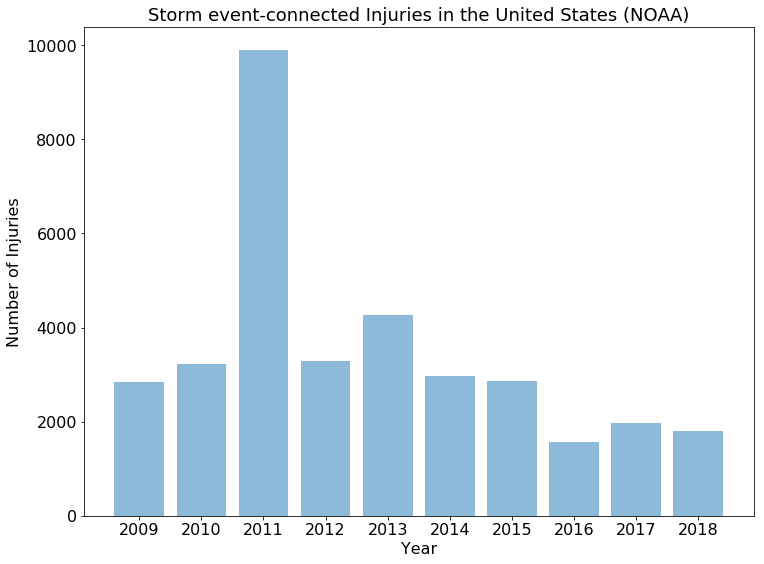

In [88]:
import matplotlib.pyplot as plt

b_ctr = np.arange(len(years))
b_label = list(years)
b_label = [list(_)[0] for _ in b_label]

plt.figure().set_size_inches(12, 9)
plt.bar(b_ctr, np.array(numInjuries[1]), align='center', alpha=0.5)
plt.xticks(b_ctr, b_label, fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Injuries', fontsize=16)
plt.title('Storm event-connected Injuries in the United States (NOAA)', fontsize=18)

# plt.show()
plt.savefig(saveLocation + 'storm_event_connected_injuries.jpeg', dpi=600, transparent=True)

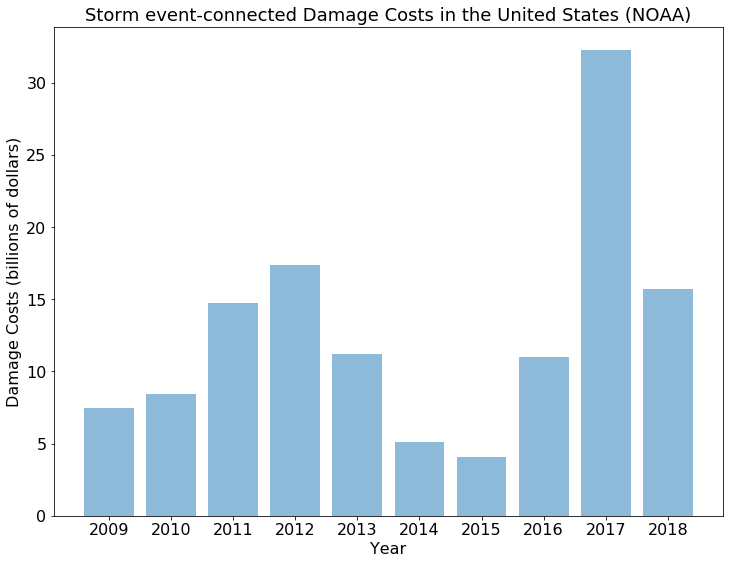

In [95]:
import matplotlib.pyplot as plt

plt.figure().set_size_inches(12, 9)
costs = [_ / 10**6 for _ in costDamage[1]]
plt.bar(b_ctr, np.array(costs), align='center', alpha=0.5)
plt.xticks(b_ctr, b_label, fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Damage Costs (billions of dollars)', fontsize=16)
plt.title('Storm event-connected Damage Costs in the United States (NOAA)', fontsize=18)

# plt.show()
plt.savefig(saveLocation + 'storm_event_connected_damage_costs.jpeg', dpi=600, transparent=True)